## Summary

We face the problem of predicting tweets sentiment. 
We have coded the text as Bag of Words and applied an SVM model. We have built a pipeline to check different hyperparameters using cross-validation. At the end, we have obtained a good model which achieve an AUC of **0.92** 

## Data loading and cleaning

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score



In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler


/Users/yashmishra12/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from sklearn import svm, grid_search, datasets
from sklearn.pipeline import make_pipeline

/Users/yashmishra12/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
data = pd.read_csv("/Users/yashmishra12/Desktop/assam.csv")

We take only the tweets we are very confident with. We use the BeautifulSoup library to process html encoding present in some tweets because scrapping.

In [6]:
data_clean = data.copy()
# data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['sentiment'] = data_clean['airline_sentiment'].\
    apply(lambda x: 1 if x=='negative' else 0)

data_clean['text_clean'] = data_clean['ttext'].apply(lambda x: BeautifulSoup(x, "lxml").text)

We are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

In [7]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0)

In [8]:
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]

In [9]:
data_clean.head(10)

,text_clean,sentiment
0,SAFE wins the first prize of Global Developmen...,0
1,RT @Nyksindia: To encourage environmental cons...,0
2,Global Climate Action Summit: China s Special ...,0
3,RT @Indian_Rivers: Amid monsoon; Assam facing ...,0
4,RT @Nyksindia: To encourage environmental cons...,0
5,RT @JamwalNidhi: @Indian_Rivers @ICD_climate @...,1
6,RT @Indian_Rivers: Amid monsoon; Assam facing ...,0
7,RT @Indian_Rivers: Amid monsoon; Assam facing ...,0
8,RT @JamwalNidhi: @Indian_Rivers @ICD_climate @...,1
9,RT @Indian_Rivers: Amid monsoon; Assam facing ...,0


## Machine Learning Model

We split the data into training and testing set:

In [10]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [11]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline to don't get features from the validation folds when building each training model.

In [12]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [13]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                             SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                     param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                     cv = kfolds,
                     scoring="roc_auc",
                     verbose=1,   
                     n_jobs=-1) 



In [14]:
grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.6s finished


0.9892076294533476

In [15]:
grid_svm.best_params_

{'svc__C': 1}

In [16]:
grid_svm.best_score_

0.987522363907964

In [17]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

Let's see how the model (with the best hyperparameters) works on the test data:

In [18]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.9753173483779972,
 'auc': 0.9892076294533476,
 'f1': 0.9586776859504132,
 'precision': 0.9806763285024155,
 'recall': 0.9376443418013857}

In [19]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [20]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

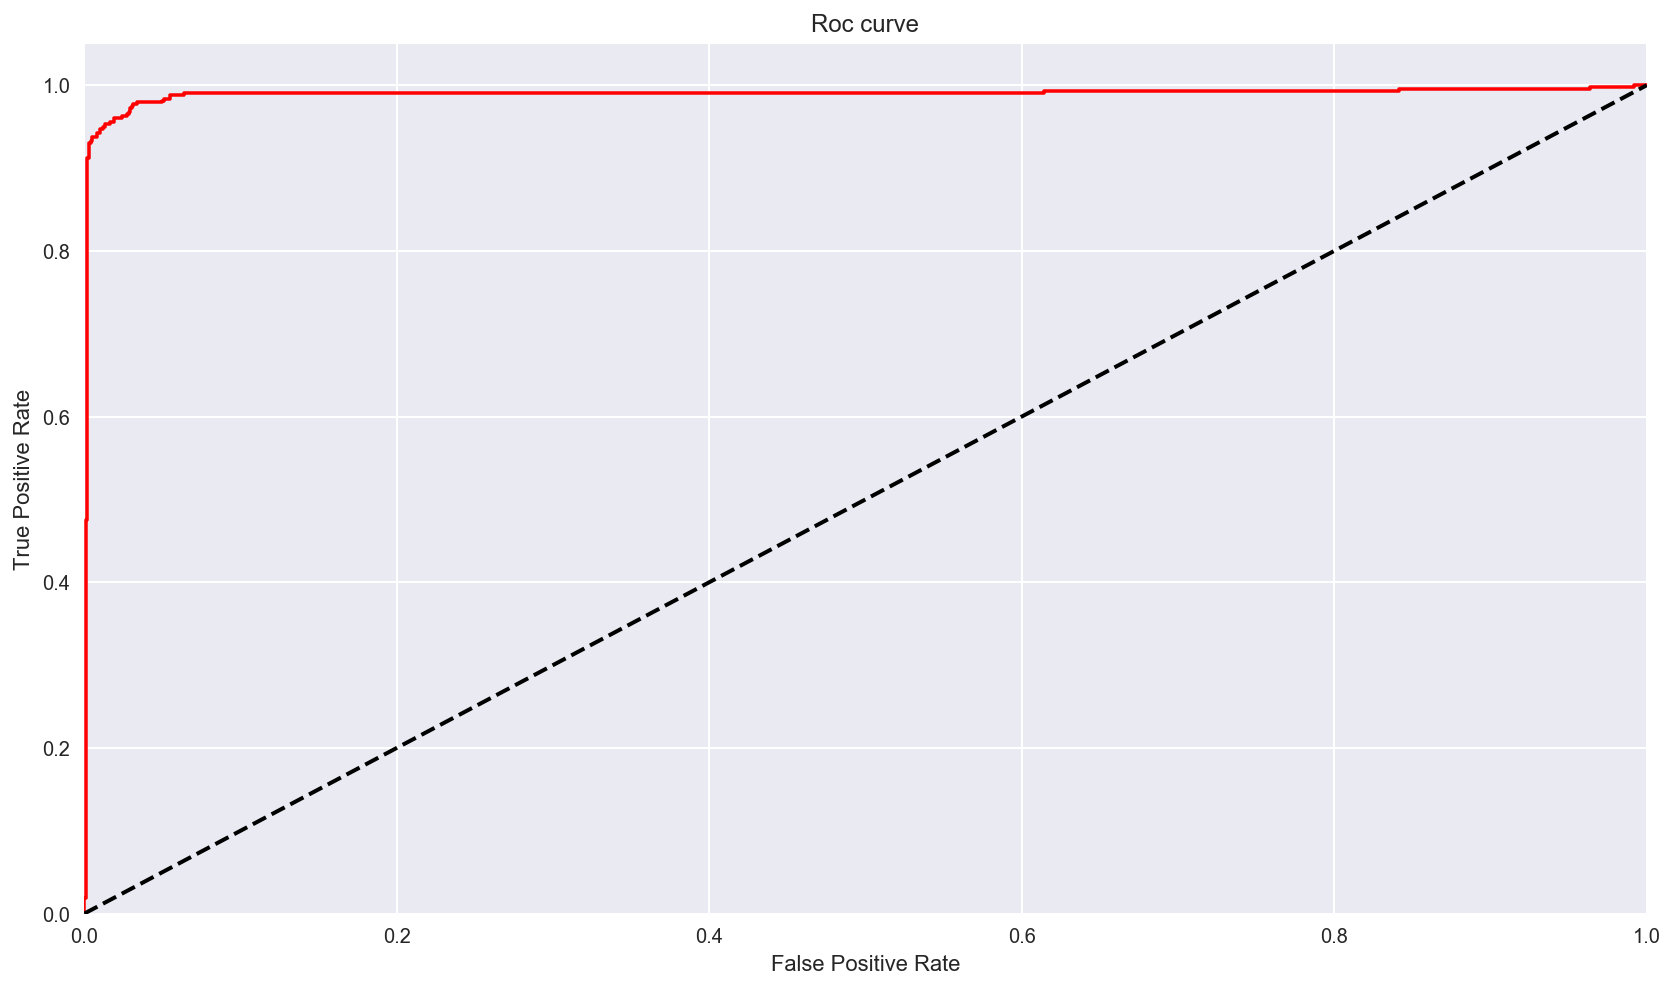

In [21]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

Let's see if our model has some bias or variance problem ploting its learning curve:

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

/Users/yashmishra12/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


In [23]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Testing score")

    plt.legend(loc="lower right")
    return plt

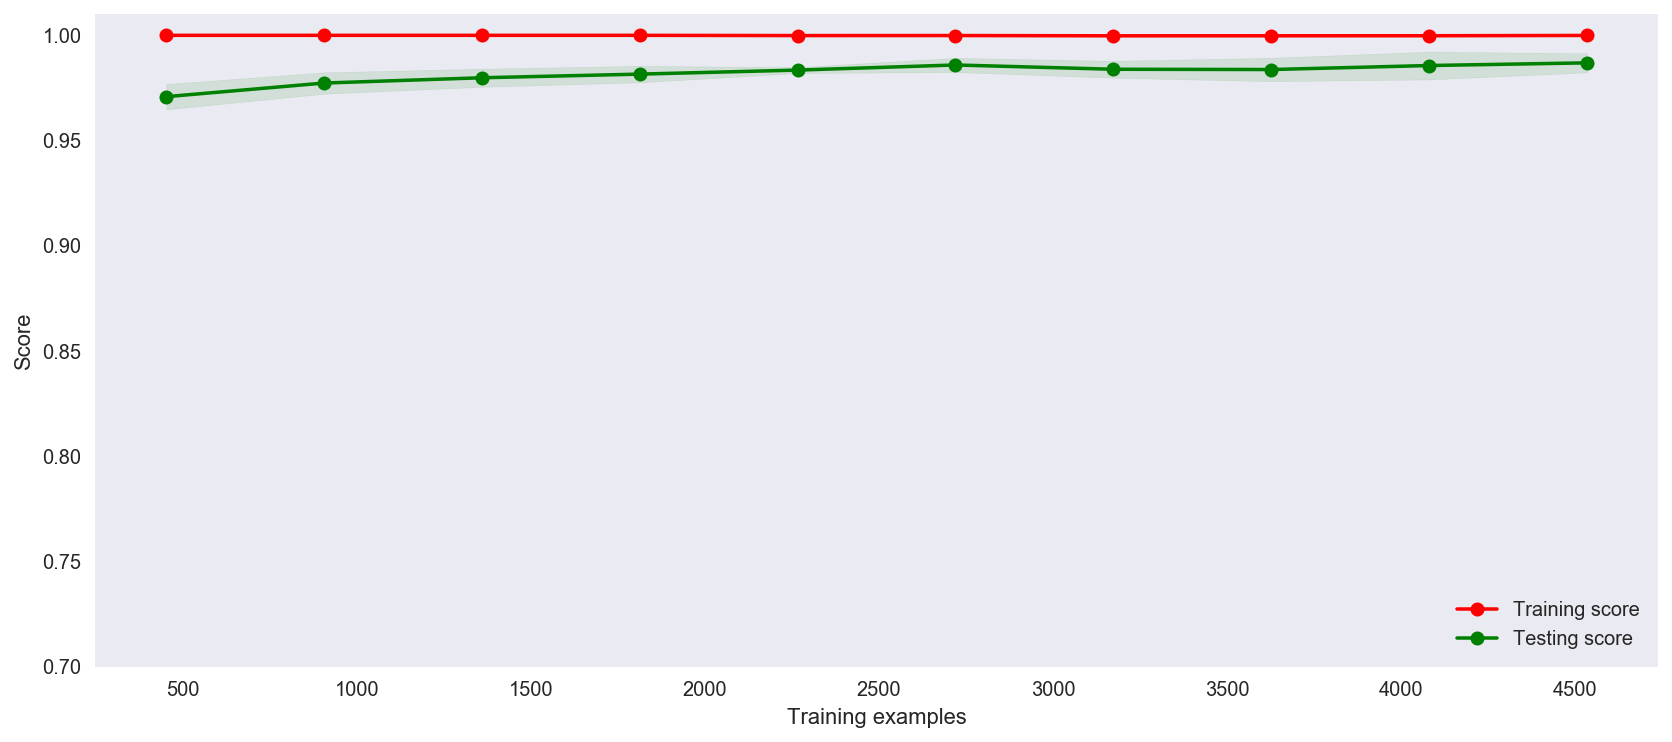

In [24]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

It looks like there isn't a big bias or variance problem, but it is clear that our model would work better with more data:. if we can get more labeled data the model performance will increase.